# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [39]:
# import libraries

# Starter code
from pyspark.sql import SparkSession, Window

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc, count, col, asc, udf, isnan, isnull,collect_list, when, hour, dayofmonth, month, year, to_timestamp
from pyspark.sql.functions import sum as Fsum

from pyspark.ml.feature import VectorAssembler, StandardScaler, IndexToString, StringIndexer, VectorIndexer

from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.util import MLUtils

from pyspark.mllib.evaluation import BinaryClassificationMetrics,  MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

from pyspark.mllib.util import MLUtils

import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Read in full sparkify dataset
def GetData(event_data):

    df = spark.read.json(event_data)
    
    return df


In [48]:
df = GetData("mini_sparkify_event_data.json") 

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.count()

286500

In [8]:
df.select("userId").dropDuplicates().count()

226

In [9]:
df.select("sessionId").dropDuplicates().count()

2354

There are 226 users created 2354 sessi

In [10]:
df.select("page").dropDuplicates().sort("page").show(40)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [11]:
#df.select('userId').distinct().show()
df.select("page").dropDuplicates().filter(col("userId")=='').show(20)

+-------------------+
|               page|
+-------------------+
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
+-------------------+



There are five pages who has no User Id

In [13]:
df.select("level").dropDuplicates().sort("level").show(10) 

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [14]:
df_unregistered = df.where(df["userAgent"].isNull())
df_unregistered.show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [15]:
df_unregistered.count()

8346

There are 8346 unregistered users that have almost no data. We should continue with registered user for further analysis.

In [4]:
def Clean_Data(df):
    return df.where(df["userAgent"].isNotNull())

In [5]:
def Get_Hour(df):
    
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
    return df.withColumn("hour", get_hour(df.ts))

In [19]:
user_log = Get_Hour(df)

In [20]:
user_log.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', hour='0'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, leve

In [21]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [22]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

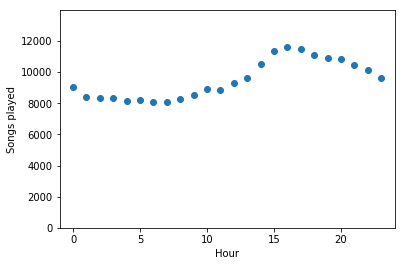

In [23]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

Users are mostly listenning music in the afternoon. 

In [24]:
gender_df = df.select('userId', 'gender') \
    .dropDuplicates().toPandas()

In [25]:
gender_df = df.select('userId', 'gender').dropDuplicates().groupBy('gender').count().toPandas()

In [26]:
gender_df = gender_df.dropna()

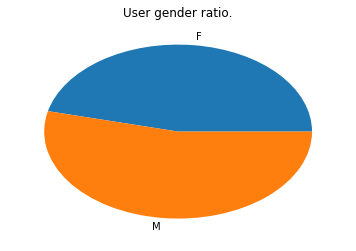

In [27]:
plt.pie(gender_df["count"], labels=gender_df["gender"])
plt.title("User gender ratio.")

plt.xlabel("")
plt.ylabel("");
plt.show()

Male users are slightly more than females

In [28]:
df.filter(df.page == 'NextSong').select('Artist').groupBy('Artist').agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')).show(20)

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
|      The Black Keys|       1125|
|                Muse|       1090|
|       Justin Bieber|       1044|
|        Jack Johnson|       1007|
|              Eminem|        953|
|           Radiohead|        884|
|     Alliance Ethnik|        876|
|               Train|        854|
|        Taylor Swift|        840|
|         OneRepublic|        828|
|         The Killers|        822|
|         Linkin Park|        787|
|         Evanescence|        781|
|            Harmonia|        729|
|       Guns N' Roses|        713|
+--------------------+-----------+
only showing top 20 rows



The first three of artists are "Kings of Leon", "Coldplay", "Florence and The Machine". This result is consisted with the artists popularity.

### Total of Some Events by Users

In [49]:
#total songs played by users
songs_total = df.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('songs_total')).orderBy('userId')
songs_total.show(5)

+------+-----------+
|userId|songs_total|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
+------+-----------+
only showing top 5 rows



In [50]:
#Total thumb ups by each users
thumbsup_total = df.where((col('page')=='Thumbs Up') &(col('userId')!='null')).groupby("userId").agg(count(col('page')).alias('thumbsup_Total')).orderBy('userId')
thumbsup_total.show(5)

+------+--------------+
|userId|thumbsup_Total|
+------+--------------+
|    10|            37|
|   100|           148|
|100001|             8|
|100002|             5|
|100003|             3|
+------+--------------+
only showing top 5 rows



In [51]:
#Total thumb downs by each users
thumbsdown_total = df.where((col("page")=='Thumbs Down')&(col('userId')!='null')).groupby("userId").agg(count(col('page')).alias('thumbsdown_total')).orderBy('userId')
thumbsdown_total.show(5)

+------+----------------+
|userId|thumbsdown_total|
+------+----------------+
|    10|               4|
|   100|              27|
|100001|               2|
|100004|              11|
|100005|               3|
+------+----------------+
only showing top 5 rows



In [52]:
#Total thumb up by each users
downgrade_total = df.where((col("page")=='Downgrade')).groupby("userId").agg(count(col('page')).alias('downgradeTotal'))
downgrade_total.show(5)

+------+--------------+
|userId|downgradeTotal|
+------+--------------+
|200002|             5|
|    51|            23|
|   124|            41|
|    54|            39|
|    15|            28|
+------+--------------+
only showing top 5 rows



In [53]:
#Total error count by each users
error_count = df.where((col("page")=='Error')&(col('userId')!='null')).groupby("userId").agg(count(col('page')).alias('error_count')).orderBy('userId')
error_count.show(5)

+------+-----------+
|userId|error_count|
+------+-----------+
|      |          6|
|   100|          3|
|100001|          1|
|100004|          2|
|100013|          2|
+------+-----------+
only showing top 5 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# create column Churn and mark rows for the users, who cancelled subscription, with Churn = 1
def fill_array(userId, cancelled_users):
    if(userId in cancelled_users): return 1
    else : return 0
    
def Define_Churn(df):
    df_churn = df.groupby('userId').agg(collect_list('page').alias('pages'))
    # define 1 as churned, 0 otherwise
    churn_f = udf(lambda x: 1 if 'Cancel' in set(x) else 0)
    df_churn = df_churn.withColumn("churn", churn_f(df_churn.pages)).drop('pages')
    df_churn = df_churn.withColumn("churn", df_churn["churn"].cast(IntegerType()))
    return df_churn

In [8]:
df = GetData("mini_sparkify_event_data.json") 
df = Clean_Data(df)

In [9]:
df_churn = Define_Churn(df)


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [27]:
def prepare_feature(data):
    #
    '''
    Preparation of features for full dataset
    INPUT:
    data - json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning
    contains the following columns:
    1. userId - initial id of the user
    2. gender - user's gender
    3. avg_events - average number of events per day for the user
    4. avg_songs - average number of songs the user listens to per day
    5. thumbs_up - total of thumbs up for each users
    6. thumbs_down - total of thumbs down for each users
    7. hour - last login hour
    8. day - last login date
    9. month - last login date
    10. year - last login year
 
    '''
    df = GetData(data) 
    df = Clean_Data(df)
    
    df_churn = Define_Churn(df)
    df = df.withColumn('is_male', when(df.gender == 'M', 1).otherwise(0))

    # Convert subscription level to binary column
    df = df.withColumn('is_paid', when(df.level == 'paid', 1).otherwise(0))
    
    
    to_time_string = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    df = df.withColumn('date',to_timestamp(to_time_string(df['ts'])))

    df = df.withColumn("hour", hour("date"))
    df = df.withColumn("day", dayofmonth("date"))
    df = df.withColumn("month", month("date"))
    df = df.withColumn("year", year("date"))
    
    
    songs_total = df.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('songs_total'))
    
    thumbsup_total = df.where((col('page')=='Thumbs Up') &(col('userId')!='null')).groupby("userId").agg(count(col('page')).alias('thumbsup_Total'))
    
    thumbsdown_total = df.where((col("page")=='Thumbs Down')&(col('userId')!='null')).groupby("userId").agg(count(col('page')).alias('thumbsdown_total'))
    
    downgrade_total = df.where((col("page")=='Downgrade')).groupby("userId").agg(count(col('page')).alias('downgradeTotal'))
    
    error_count = df.where((col("page")=='Error')&(col('userId')!='null')).groupby("userId").agg(count(col('page')).alias('error_count'))
    
    #create temp table for calculation last time login
    df.createOrReplaceTempView("temp_df")
    df_lastts = spark.sql('''
          SELECT userId, max(ts) AS last_ts
          FROM temp_df 
          group by userId
          '''
          )
    
    #get the latest data for each users
    df = df.join(df_lastts, df.userId == df_lastts.userId)
    df = df.filter(df.last_ts == df.ts)
    
    #selected feature list for machine learning
    featured_list = ['temp_df.userId', 'is_male', 'is_paid', 'hour', 'day', 'month', 'year']

    df_featured = df.select(featured_list)
    
    df_featured = df_featured.withColumnRenamed("temp_df.userId", "userId")
    
    df_featured = df_featured.join(songs_total, "userId").\
    join(thumbsup_total, "userId").join(thumbsdown_total, "userId").\
    join(downgrade_total, "userId").join(error_count, "userId").join(df_churn, "userId")
    
    return df_featured

In [28]:
df_featured = prepare_feature("mini_sparkify_event_data.json")

In [29]:
df_featured.show(5)

+------+-------+-------+----+---+-----+----+-----------+--------------+----------------+--------------+-----------+-----+
|userId|is_male|is_paid|hour|day|month|year|songs_total|thumbsup_Total|thumbsdown_total|downgradeTotal|error_count|churn|
+------+-------+-------+----+---+-----+----+-----------+--------------+----------------+--------------+-----------+-----+
|   124|      0|      1|  15| 30|   11|2018|       4079|           171|              41|            41|          6|    0|
|    51|      1|      1|   7| 17|   10|2018|       2111|           100|              21|            23|          1|    1|
|    15|      1|      1|   4| 25|   11|2018|       1914|            81|              14|            28|          2|    0|
|    54|      0|      1|  19| 12|   11|2018|       2841|           163|              29|            39|          1|    1|
|   155|      0|      1|  11| 28|   11|2018|        820|            58|               3|            12|          3|    0|
+------+-------+-------+

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Assemble all features into one

In [30]:
vector_assembler = VectorAssembler(inputCols=["hour","day","month","year","songs_total", "thumbsup_Total", "thumbsdown_total", "downgradeTotal" , "error_count"], outputCol="rawFeatures")
df_ml = vector_assembler.transform(df_featured)

In [31]:
df_ml.select('userId', 'churn', 'rawFeatures').show(5)

+------+-----+--------------------+
|userId|churn|         rawFeatures|
+------+-----+--------------------+
|   124|    0|[15.0,30.0,11.0,2...|
|    51|    1|[7.0,17.0,10.0,20...|
|    15|    0|[4.0,25.0,11.0,20...|
|    54|    1|[19.0,12.0,11.0,2...|
|   155|    0|[11.0,28.0,11.0,2...|
+------+-----+--------------------+
only showing top 5 rows



Do the standart scaling for features

In [32]:
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(df_ml)
df_ml = scalerModel.transform(df_ml)

In [33]:
df_ml.select('userId', 'churn', 'features').show(5)

+------+-----+--------------------+
|userId|churn|            features|
+------+-----+--------------------+
|   124|    0|[2.15046215163503...|
|    51|    1|[1.00354900409634...|
|    15|    0|[0.57345657376934...|
|    54|    1|[2.72391872540437...|
|   155|    0|[1.57700557786569...|
+------+-----+--------------------+
only showing top 5 rows



Spiliting features into %80, %20 for trainning and testing

In [34]:
train_df, test_df = df_featured.randomSplit([0.8, 0.2], seed = 42)

In [35]:
rfc = RandomForestClassifier(labelCol="churn", featuresCol="features", numTrees=14)

# assemble pipeline
pipeline = Pipeline(stages = [vector_assembler, scalerModel, rfc])

In [36]:

model = pipeline.fit(train_df)

In [37]:
pred_train = model.transform(train_df)
pred_test = model.transform(test_df)

In [44]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(pred_test)
print("F1 score = %g" % (f1_score))

F1 score = 0.928


In [55]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_test)
print("Validation Error = %g" % (1.0 - accuracy))

Validation Error = 0.0666667


# Conclusion

F1 Score is %92.8 and Error is %6. It is pretty good, the feature selection, the model and the related parameters choosen is pretty good. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])